# Data Structuring and Analysis

In [179]:
from googleapiclient.discovery import build
from tqdm import tqdm
import pandas as pd
from  pathlib import Path
import kagglehub
import importlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
import functions as fc
importlib.reload(fc)

<module 'functions' from '/Users/hanane/Ironhack/projects/project_youtube_data_wrangling/functions.py'>

In [148]:
df = fc.load_data("jashwanthreddya/youtube")

'if it's your first time running this notebook code — no CSVs yet (runs the API calls and creates the CSVs):
    #Load raw data from Kaggle
    df = load_data("jashwanthreddya/youtube")

    #Fetch channel stats from API → creates channels_data.csv
    subs_df = get_channel_stats(df, API_KEY)

    #Fetch video categories from API → creates video_categories.csv
    df_categories = get_videos_with_category_names(df, API_KEY)

    #Fetch top 5 videos stats from API → creates top5_videos_api.csv
    top5_videos = df_new.sort_values("engagement_rate", ascending=False).head(5)
    new_video_df = get_top5_stats(top5_videos, API_KEY)
    new_video_df = save_top5(new_video_df, top5_videos)

In [121]:
channels_df = pd.read_csv("channels_data.csv")
df_categories = pd.read_csv("video_categories.csv")
new_video_df = pd.read_csv("top5_videos_api.csv")

### Cleaning and restructuring the data 

In [122]:
#merging the data to get categories with the rese of video data
df_new = pd.merge(df, df_categories, 
                  on="video_id", 
                  how="left")
df_new.head(1)

,video_id,title,channel_id,channel_title,published_at,view_count,likes,dislikes,comment_count,tags,description,comments,category_id,category_name
0,--0bCF-iK2E,Jadon Sancho Magical Skills & Goals,UC6UL29enLNe4mqwTfAyeNuw,Bundesliga,2021-07-01 10:00:00,1048888,19515,226,1319,football soccer ftbol alemn Bundesliga season ...,Enjoy the best skills and goals from Jadon San...,"Respect to Dortmund fans,must be sad losing hi...",17.0,Sports


In [123]:
# Cleaning category_id to rid off .0 in the id:
# regex=False means treat ".0" as a plain string, not a regular expression (regex).
# It removes .0 from the end of numbers that look like "17.0" → "17".
df_new["category_id"] = (df_new["category_id"].astype(str).str.replace(".0", "", regex=False))

In [124]:
### Cleaning the data with functions:
df_new = fc.standardize_column_names(df_new)
df_new = fc.fill_missing_values(df_new)

#### Observation: there may be miltiple categories per channel:

In [125]:
#Example to show that for one channel there are two related video categories: ex. Sky Sports Football >> 'Sports' 'Entertainment'.
cat_channel = df_new[df_new["channel_title"] == "NBA"]["category_name"].unique()
print(cat_channel)

['Sports' nan]


In [126]:
pivot_sum = pd.pivot_table(
    df_new,
    values="view_count",
    index="category_name",
    aggfunc="sum"
)
pivot_pct = (pivot_sum / pivot_sum.values.sum() * 100).round()
pivot_pct_desc = pivot_pct.sort_values(by="view_count", ascending=False)

pivot_pct_desc.head(10)

,view_count
category_name,
Music,47.0
Entertainment,19.0
Gaming,8.0
People & Blogs,7.0
Comedy,5.0
Sports,5.0
Film & Animation,2.0
Howto & Style,2.0
Science & Technology,2.0


#### Structuruing and cleaning the channel dataframe

In [151]:
channels_df = fc.map_channel_titles(channels_df, df_new)
channels_df = fc.drop_missing_counts(channels_df)
channels_df = fc.convert_to_int(channels_df)
channels_df = fc.drop_duplicate_channels(channels_df)

In [127]:
df_new.columns

Index(['video_id', 'title', 'channel_id', 'channel_title', 'published_at',
       'view_count', 'likes', 'dislikes', 'comment_count', 'tags',
       'description', 'comments', 'category_id', 'category_name'],
      dtype='object')

In [128]:
channels_df.columns

Index(['channel_id', 'subscriberCount', 'viewCount', 'videoCount'], dtype='object')

### Hypothesis 1: 
#### - The average engagement rate of videos exceeds 4% (engagement rate  : (likes + comments)/views)

In [186]:
df_new["engagement_rate"] = (df_new["likes"] + df_new["comment_count"]) / df_new["view_count"] * 100
df_new["engagement_rate"].head()

0    1.986294
1    2.462157
2    1.301551
3    1.623109
4    4.744007
Name: engagement_rate, dtype: float64

In [188]:
average_engagement = df_new["engagement_rate"].mean()
average_engagement

np.float64(4.1635073196267465)

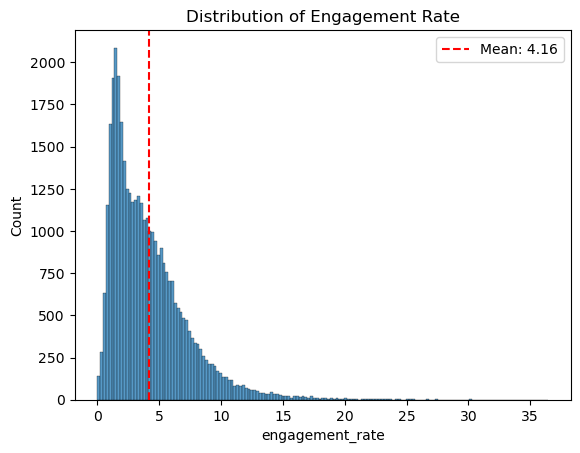

In [189]:
sns.histplot(data=df_new, x="engagement_rate")

plt.axvline(average_engagement, color="red", linestyle="--", label=f"Mean: {average_engagement:.2f}")

plt.title("Distribution of Engagement Rate")
plt.legend()
plt.show()

In [190]:
df_egagement_rate_4 = df_new[df_new['engagement_rate']> 4]
percentage = round(len(df_egagement_rate_4) / len(df_new) * 100,2)
print(percentage, "of videos published have an engagement rate above 4%")

42.36 of videos published have an engagement rate above 4%


In [191]:
# average engagement rate by category
pivot = df_new.pivot_table(
    values=["engagement_rate", "video_id"],
    index="category_name",
    aggfunc={"engagement_rate": "mean", "video_id": "count"}
)

# rename columns to make it cleaner
pivot.columns = ["avg_engagement_rate", "video_count"]
print(pivot)

                       avg_engagement_rate  video_count
category_name                                          
Autos & Vehicles                  3.880628          832
Comedy                            6.036738         1920
Education                         5.266307          694
Entertainment                     4.539996         8219
Film & Animation                  4.264150          972
Gaming                            5.132498         4571
Howto & Style                     4.607464         1095
Music                             3.914165         5381
News & Politics                   1.943156         1279
Nonprofits & Activism             7.222924           20
People & Blogs                    5.489558         2984
Pets & Animals                    4.040537          161
Science & Technology              4.676196         1052
Sports                            2.286732         6133
Travel & Events                   4.598958          206


In [192]:
pivot = pivot.reset_index()

pivot = pivot.sort_values("category_name")

# get the same order for countplot
category_order = pivot["category_name"].tolist()

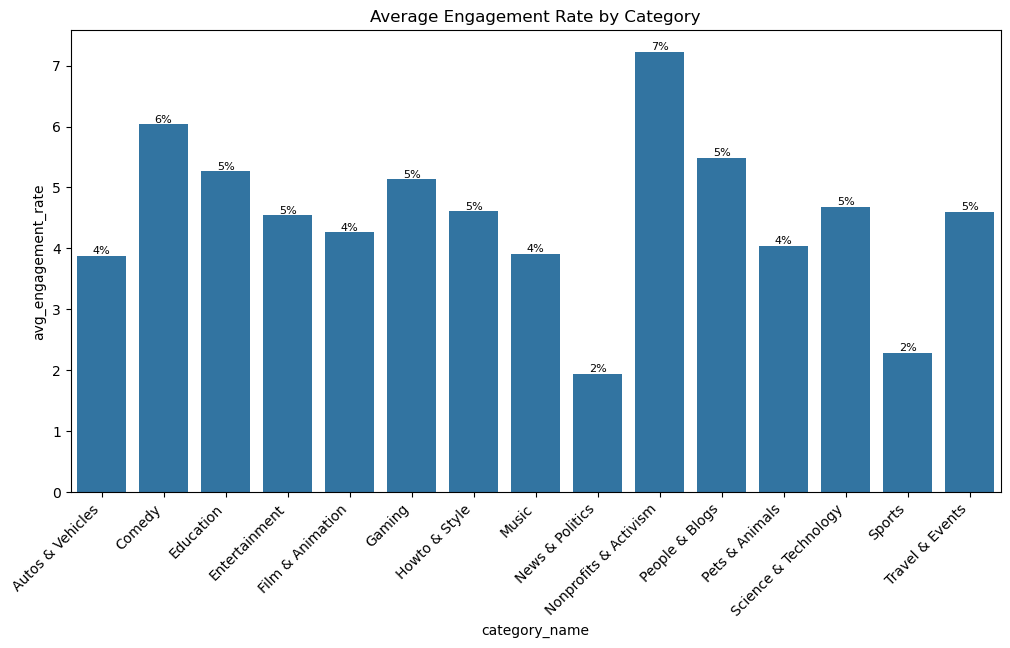

In [193]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=pivot, x="category_name", y="avg_engagement_rate", order=category_order)
for bar in ax.containers:
    for rect in bar:
        height = rect.get_height()
        label = f'{height:.0f}%'
        ax.text(rect.get_x() + rect.get_width()/2, height, label, ha='center', va='bottom', fontsize=8)
plt.xticks(rotation=45, ha="right")
plt.title("Average Engagement Rate by Category")
plt.show()

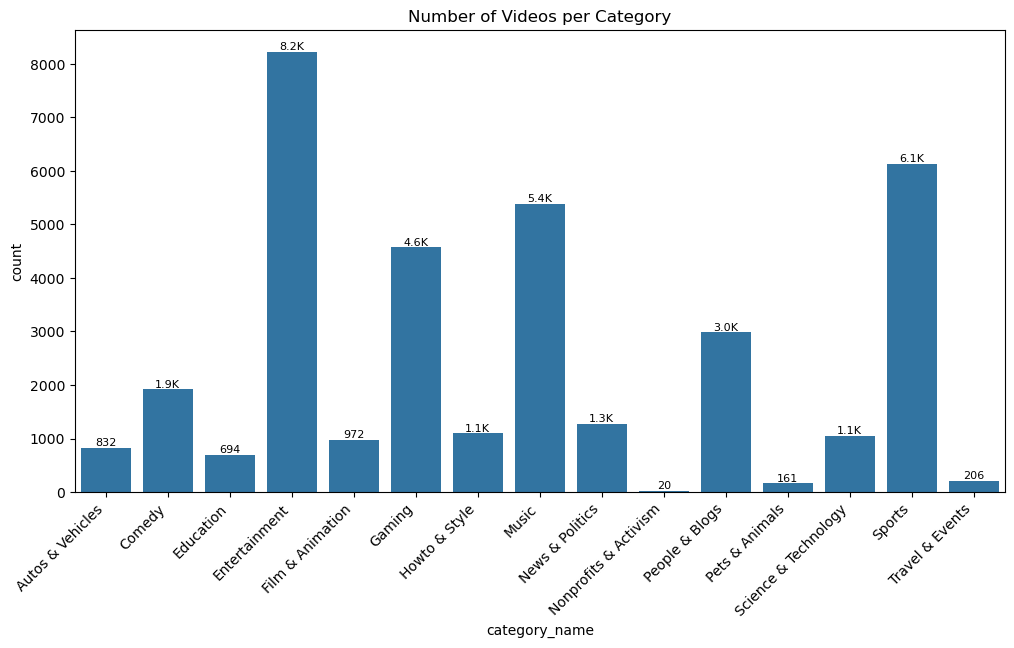

In [194]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df_new, x="category_name", order=category_order)
for bar in ax.containers:
    for rect in bar:
        height = rect.get_height()
        if height >= 1000:
            label = f'{height/1000:.1f}K'
        else:
            label = f'{height:.0f}'
        ax.text(rect.get_x() + rect.get_width()/2, height, label, ha='center', va='bottom', fontsize=8)
plt.xticks(rotation=45, ha="right")
plt.title("Number of Videos per Category")
plt.show()

### Hypothesis 2: 
#### Top videos/channels in terms of views receive the highest number of reactions (+25% compared to average channels).

In [130]:
# Top Channels  in terms of views have the highest reactions (25%  than average channels).
pivot_sum = pd.pivot_table(
    df_new,
    values=["view_count", "likes", "comment_count"],
    index="channel_title",
    aggfunc="sum"
)

pivot_sum["total_reactions"] = (pivot_sum["likes"] + pivot_sum["comment_count"])
total_all = pivot_sum["total_reactions"].sum()
pivot_sum["%_reactions"] = (pivot_sum["total_reactions"] / total_all * 100).round(1)

total_views = pivot_sum["view_count"].sum()
pivot_sum["%_views"] = (pivot_sum["view_count"] / total_views * 100).round(1)

pivot_sum[['%_views', '%_reactions']].sort_values("%_views", ascending=False)

,%_views,%_reactions
channel_title,,
HYBE LABELS,2.0,3.4
BLACKPINK,1.6,2.2
MrBeast,1.5,2.0
Bad Bunny,1.1,0.4
JYP Entertainment,1.0,1.1
...,...,...
GrantTheGoat,0.0,0.0
Graser,0.0,0.0
Grassroot Entertainment,0.0,0.0


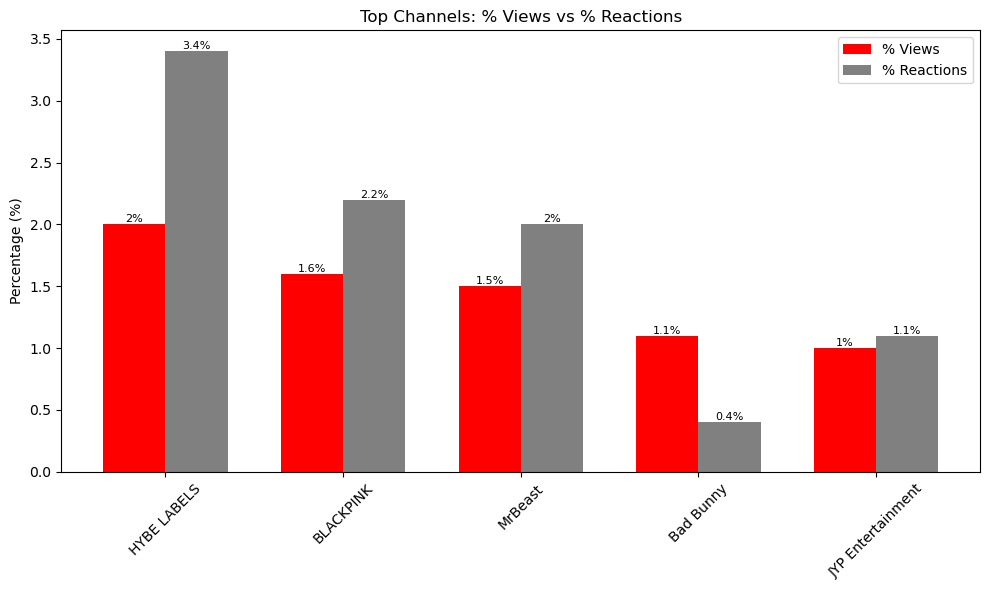

In [131]:
# Histogram with the Top Channels  in terms of % of Views with the % of Reactions:
import matplotlib.pyplot as plt
import numpy as np

top_channels = pivot_sum[['%_views', '%_reactions']] \
    .sort_values("%_views", ascending=False) \
    .head(5)

x = np.arange(len(top_channels.index))
width = 0.35

plt.figure(figsize=(10,6))

bars1 = plt.bar(x - width/2, top_channels['%_views'], width, label='% Views', color="red")
bars2 = plt.bar(x + width/2, top_channels['%_reactions'], width, label='% Reactions', color="grey")

plt.xticks(x, top_channels.index, rotation=45)
plt.ylabel("Percentage (%)")
plt.title("Top Channels: % Views vs % Reactions")
plt.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            height,
            f'{height:g}%',
            ha='center',
            va='bottom',
            fontsize=8
        )

plt.tight_layout()
plt.show()

In [132]:
# Average for the the % reactions (likes+comments):
print(pivot_sum["%_reactions"].mean().round(4))
print(pivot_sum["%_views"].mean().round(4))

0.0059
0.006


### Hypothesis 3: 
#### - Some categories (e.g., Music/ Sport  vs. News) have significantly higher average views.
#### - The ratio of dislikes to total reactions (likes + dislikes) is the same across categories.


In [133]:
#2 bis/among these categories :  
# The ratio of dislikes to total reactions (likes + dislikes) is the same across categories.
pivot_sum = pd.pivot_table(
    df_new,
    values=["likes", "dislikes"],
    index="category_name",
    aggfunc="sum"
)

pivot_sum["total_reactions"] = (pivot_sum["likes"] + pivot_sum["dislikes"])
total_all = pivot_sum["total_reactions"].sum()
pivot_sum["%_reactions"] = (pivot_sum["total_reactions"] / total_all * 100).round()

pivot_sum["%_likes"] = (pivot_sum["likes"] / pivot_sum["total_reactions"] * 100).round()

pivot_sum["%_dislikes"] = (pivot_sum["dislikes"] / pivot_sum["total_reactions"] * 100).round()

pivot_sum[['%_reactions', '%_likes', '%_dislikes']].sort_values("%_dislikes", ascending=False)

,%_reactions,%_likes,%_dislikes
category_name,,,
News & Politics,0.0,91.0,9.0
Comedy,7.0,96.0,4.0
Howto & Style,2.0,96.0,4.0
Autos & Vehicles,1.0,97.0,3.0
Entertainment,23.0,97.0,3.0
Music,34.0,97.0,3.0
Nonprofits & Activism,0.0,97.0,3.0
People & Blogs,10.0,97.0,3.0
Science & Technology,3.0,97.0,3.0


In [134]:
# Average for the the % reactions and dislikes:
print(pivot_sum["%_reactions"].mean().round())
print(pivot_sum["%_likes"].mean().round())
print(pivot_sum["%_dislikes"].mean().round())

7.0
97.0
3.0


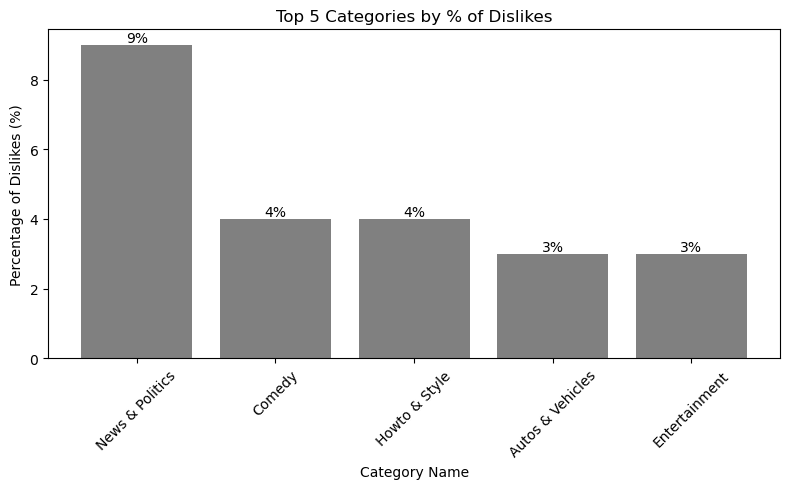

In [135]:
# Histomgram to show the Top 5 Categories by % of Dislikes:
import matplotlib.pyplot as plt

top5 = pivot_sum['%_dislikes'].sort_values(ascending=False).head(5)

plt.figure(figsize=(8,5))
bars = plt.bar(top5.index, top5.values, color='grey')

plt.title("Top 5 Categories by % of Dislikes")
plt.ylabel("Percentage of Dislikes (%)")
plt.xlabel("Category Name")
plt.xticks(rotation=45)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f'{height:g}%',
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()

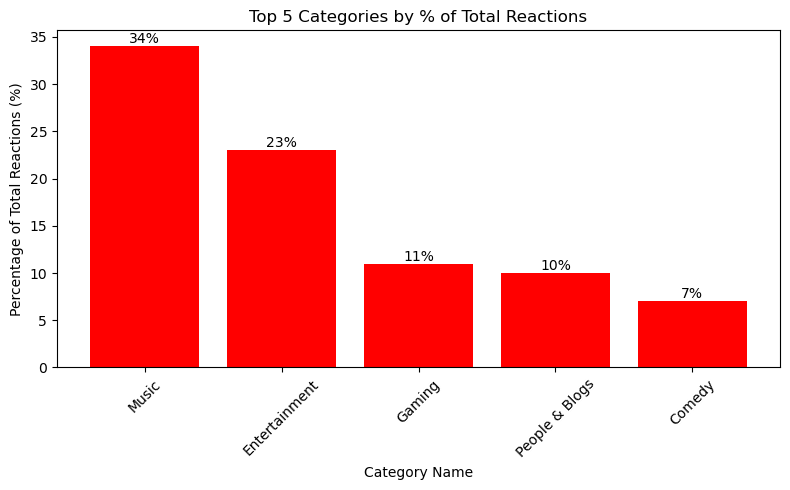

In [136]:
# Histomgram to show the Top 5 Categories by % of Total Reactions:
import matplotlib.pyplot as plt

top5 = pivot_sum['%_reactions'].sort_values(ascending=False).head(5)

plt.figure(figsize=(8,5))
bars = plt.bar(top5.index, top5.values, color='red')

plt.title("Top 5 Categories by % of Total Reactions")
plt.ylabel("Percentage of Total Reactions (%)")
plt.xlabel("Category Name")
plt.xticks(rotation=45)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f'{height:g}%',
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()

In [137]:
channels_df = pd.read_csv("channels_data.csv")
channels_df.shape

(11992, 4)

### Hypothesis 4: 
#### - Channels with the highest number of subscribers have published the most videos

In [152]:
top10 = channels_df.sort_values("subscriberCount", ascending=False).head(10)

In [153]:
top10[["channel_title", "subscriberCount", "videoCount"]]

,channel_title,subscriberCount,videoCount
816,MrBeast,468000000,945
851,T-Series,310000000,25513
4279,SET India,188000000,166813
7123,Stokes Twins,137000000,420
5531,Zee Music Company,122000000,15763
199,WWE,112000000,91285
1283,PewDiePie,110000000,4657
425,Sony SAB,105000000,107966
578,BLACKPINK,100000000,651
1532,Alan Chikin Chow,99700000,1595


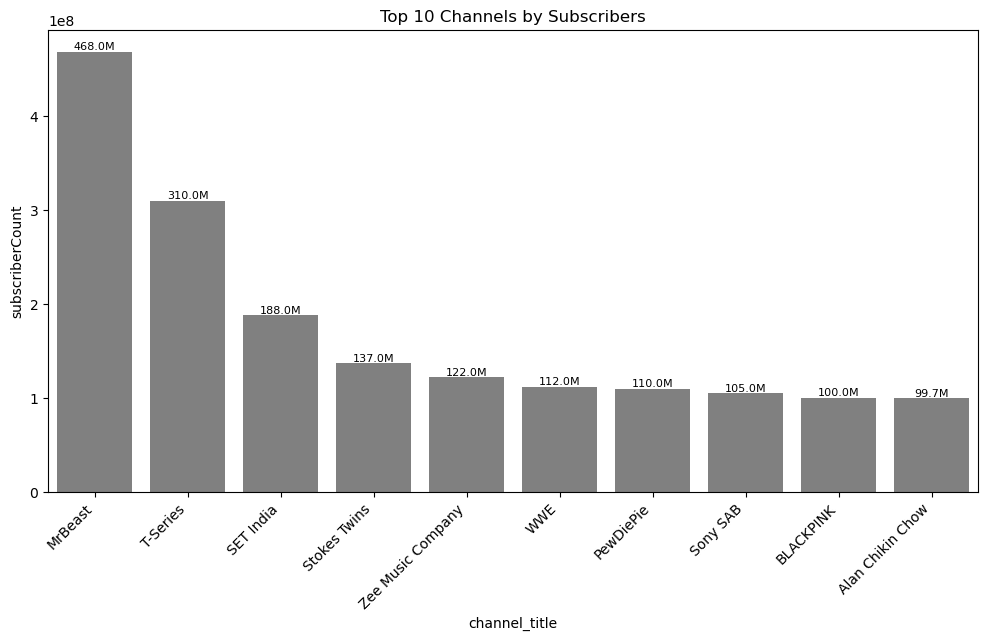

In [158]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=top10, x="channel_title", y="subscriberCount", color="grey")

# add values on top of bars in M or K
for bar in ax.containers:
    for rect in bar:
        height = rect.get_height()
        if height >= 1000000:
            label = f'{height/1000000:.1f}M'
        else:
            label = f'{height/1000:.1f}K'
        ax.text(rect.get_x() + rect.get_width()/2, height, label, ha='center', va='bottom', fontsize=8)

plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Channels by Subscribers")
plt.show()

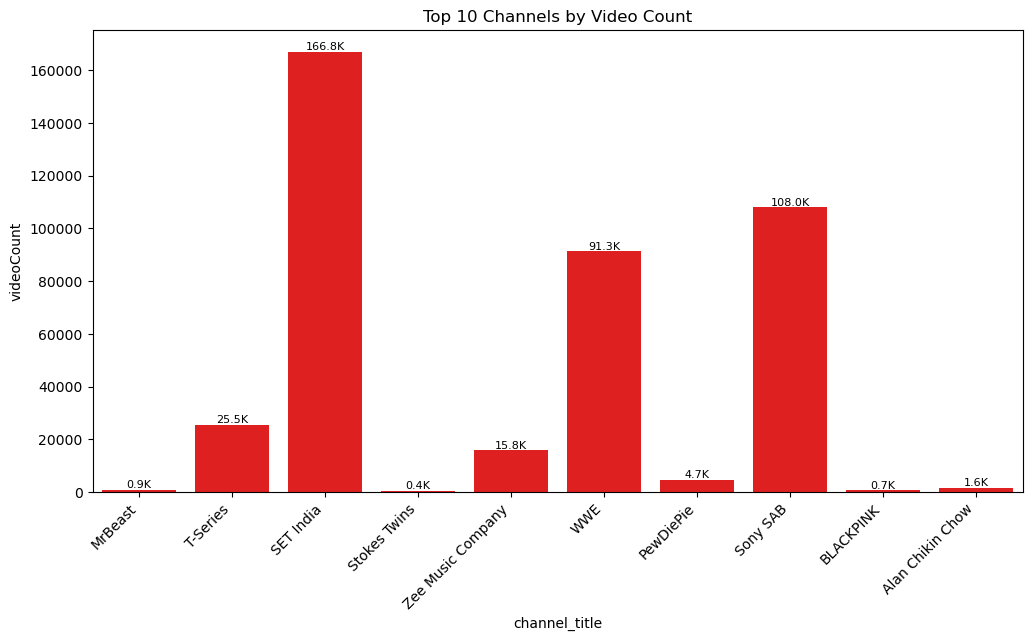

In [159]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=top10, x="channel_title", y="videoCount", color="red")

# add values on top of bars in M or K
for bar in ax.containers:
    for rect in bar:
        height = rect.get_height()
        if height >= 1000000:
            label = f'{height/1000000:.1f}M'
        else:
            label = f'{height/1000:.1f}K'
        ax.text(rect.get_x() + rect.get_width()/2, height, label, ha='center', va='bottom', fontsize=8)

plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Channels by Video Count")
plt.show()

In [164]:
#calculating the engagement rate  and adding it in a new column of the videos dataframe ( kaggle data set)
df["engagement_rate"] = (df["likes"] + df["comment_count"]) / df["view_count"] * 100
df["engagement_rate"].head(10)

0    1.986294
1    2.462157
2    1.301551
3    1.623109
4    4.744007
5    2.836631
6    6.491531
7    6.390394
8    2.075904
9    1.946175
Name: engagement_rate, dtype: float64

In [165]:
chan_avg_engagement = df.groupby("channel_id")["engagement_rate"].mean().reset_index()
chan_avg_engagement.columns = ["channel_id", "avg_engagement_rate"]


In [166]:
channels_df["avg_engagement_rate"] = channels_df["channel_id"].map(chan_avg_engagement.set_index("channel_id")["avg_engagement_rate"])

In [167]:
top10 = channels_df.sort_values("subscriberCount", ascending=False).head(10)

Text(0.5, 1.0, 'Average Engagement Rate for Top 10 Channels')

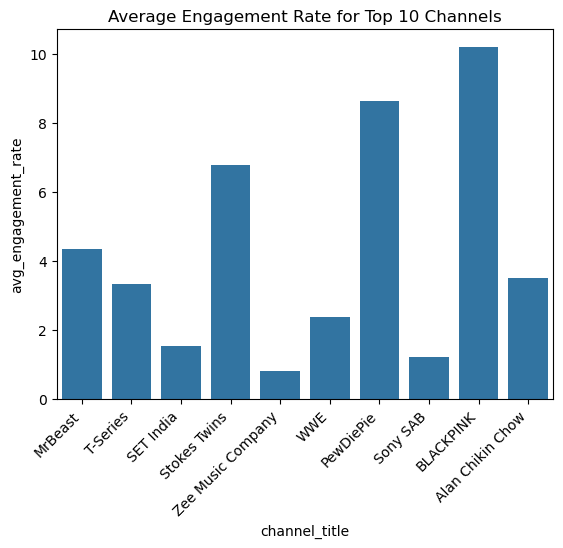

In [168]:
sns.barplot(data=top10, x="channel_title", y="avg_engagement_rate")
plt.xticks(rotation=45, ha="right")
plt.title("Average Engagement Rate for Top 10 Channels")

### Hypotheiss 5 bonus :
#### Comparing top 5 videos with the best enagagament rate evolution

In [195]:
top5_videos = df_new.sort_values("engagement_rate", ascending=False).head(5)
top5_videos.head(3)

,video_id,title,channel_id,channel_title,published_at,view_count,likes,dislikes,comment_count,tags,description,comments,category_id,category_name,engagement_rate
22885,ayljcyrhqdw,12 iPhone 12 For You - Celebrating 5 Years Of ...,UCOhHO2ICt0ti9KAh-QHvttQ,Technical Guruji,2020-10-30 06:20:00,2518835,538482,4061,379888,Technical guruji iphone iphone 12 iphone 12 pr...,Enter here: https://gleam.io/0tjRI/tg-12-iphon...,Love you #TGFamily...Enter here: https://gleam...,28,Science & Technology,36.460110
28120,k-I-3E0WM_U,"Stray Kids '' M/V 100M Views ""Special Thanks T...",UC9rMiEjNaCSsebs31MRDCRA,Stray Kids,2020-08-27 09:30:53,726929,225491,180,17187,Stray Kids SKZ BANG CHAN LEE KNOW MINHO ...,"Stray Kids( ) '' M/V 100M Views ""Special Thank...","idk but this video is really heartwarming, the...",22,People & Blogs,33.384003
6121,9P4bMIDpWXw,IT'S MY BIRTHDAY SO YOU HAVE TO CLICK ON THIS ...,UCiYcA0gJzg855iSKMrX3oHg,CoryxKenshin,2020-11-09 23:45:38,2919371,813125,3918,139824,its my birthday so you have to click on this v...,"For real though, thank you all so much for the...",Happy Birthday CoryxKenshin!! Hope its a great...,20,Gaming,32.642271


In [196]:
# load both datasets
# new data
new_video_df = pd.read_csv("/Users/hanane/Ironhack/projects/project_youtube_data_wrangling/top5_videos_api.csv")
new_video_df.columns

Index(['video_id', 'new_views', 'new_likes', 'new_comments', 'title'], dtype='object')

In [197]:
# old data
top5_videos = df_new.sort_values("engagement_rate", ascending=False).head(5)
top5_videos.columns

Index(['video_id', 'title', 'channel_id', 'channel_title', 'published_at',
       'view_count', 'likes', 'dislikes', 'comment_count', 'tags',
       'description', 'comments', 'category_id', 'category_name',
       'engagement_rate'],
      dtype='object')

In [198]:
comparison_df = top5_videos.merge(new_video_df, on="video_id", how="left")

In [199]:
comparison_df["new_engagement_rate"] = (comparison_df["new_likes"] + comparison_df["new_comments"]) / comparison_df["new_views"] * 100

comparison_df["evolution"] = comparison_df["new_engagement_rate"] - comparison_df["engagement_rate"]

comparison_df[["title_x", "engagement_rate", "new_engagement_rate", "evolution"]]

,title_x,engagement_rate,new_engagement_rate,evolution
0,12 iPhone 12 For You - Celebrating 5 Years Of ...,36.460110,34.732369,-1.727740
1,"Stray Kids '' M/V 100M Views ""Special Thanks T...",33.384003,31.511086,-1.872918
2,IT'S MY BIRTHDAY SO YOU HAVE TO CLICK ON THIS ...,32.642271,29.140740,-3.501531
3,Stray Kids Scars Music Video Unit Teaser (Lee ...,32.131772,29.107891,-3.023880
4,FALSAFA | Tanzeel Khan | DASTAAN,31.443973,9.582813,-21.861160


In [202]:
comparison_df["video_label"] = ["Video A", "Video B", "Video C", "Video D", "Video E"]

In [205]:
plot_melted = comparison_df[["video_label", "engagement_rate", "new_engagement_rate"]].melt(
    id_vars="video_label",
    var_name="period",
    value_name="rate")

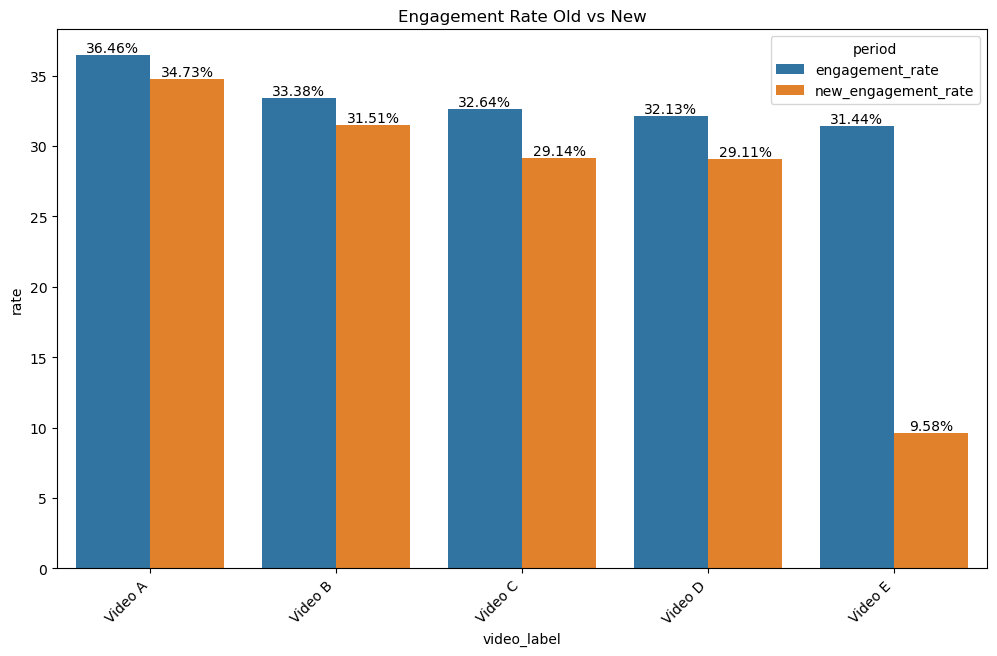

In [208]:
plt.figure(figsize=(12, 7))
ax = sns.barplot(data=plot_melted, x="video_label", y="rate", hue="period")

for bar in ax.containers:
    ax.bar_label(bar, fmt="%.2f%%")

plt.xticks(rotation=45, ha="right")
plt.title("Engagement Rate Old vs New")
plt.show()